1. Разработка: препроцессинг до чанкования

2. Разработка: чанкование

3. Полный пайплайн предобработки

4. Сформируем чанки для первой реализации

5. Получим тестовые эмбединги

In [1]:
import pandas as pd
import numpy as np
from typing import Any
import tiktoken

In [2]:
# Тренировочный датасет
data = pd.read_csv('data/train_data.csv')

data.head()

,id,annotation,tags,text
0,doc_001,Светлана из Казани дает частные уроки английск...,"['Начать бизнес', 'Самозанятые', 'Свое дело', ...",## Кто такой самозанятый?\n\nПо закону самозан...
1,doc_002,"Елене назначили социальное пособие на ребенка,...","['Защитить права', 'Банки', 'Банковская карта'...",Первым делом нужно попросить банк проверить ма...
2,doc_003,Самый надежный способ не оказаться в долгах — ...,"['Кредиты', 'Долги', 'Просрочки', 'Ипотека', '...",## Не переоценивайте свои финансовые возможнос...
3,doc_004,"Друзья Александра то и дело хвастаются, что по...","['Инвестиции', 'Ценные бумаги', 'Фондовая бирж...",Просто прийти на биржу и купить ценные бумаги ...
4,doc_005,Вы взяли в микрофинансовой организации заем на...,"['Займы', 'Долги', 'Риски', 'Защитить права']","## МФО больше нет в госреестре. Значит, она за..."


In [3]:
df = data.copy()

## 1. Разработка: препроцессинг до чанкования

In [4]:
def first_preprocess(df):
    # annotation
    df['annotation'] = df['annotation'].apply(lambda x: '' if x is np.nan else x)

    # tags
    df['tags'] = [row[1:-1].replace("'", "") for row in df['tags']]

    # text
    df['text'] = df['text'].str.replace(r'Обновлено \d{2}\.\d{2}\.\d{4} в \d{2}:\d{2}', '', regex=True)

    return df

In [5]:
df = first_preprocess(df)

df.head()

,id,annotation,tags,text
0,doc_001,Светлана из Казани дает частные уроки английск...,"Начать бизнес, Самозанятые, Свое дело, Налоги",## Кто такой самозанятый?\n\nПо закону самозан...
1,doc_002,"Елене назначили социальное пособие на ребенка,...","Защитить права, Банки, Банковская карта, Риски...",Первым делом нужно попросить банк проверить ма...
2,doc_003,Самый надежный способ не оказаться в долгах — ...,"Кредиты, Долги, Просрочки, Ипотека, Кредитная ...",## Не переоценивайте свои финансовые возможнос...
3,doc_004,"Друзья Александра то и дело хвастаются, что по...","Инвестиции, Ценные бумаги, Фондовая биржа, Акц...",Просто прийти на биржу и купить ценные бумаги ...
4,doc_005,Вы взяли в микрофинансовой организации заем на...,"Займы, Долги, Риски, Защитить права","## МФО больше нет в госреестре. Значит, она за..."


### Обработка text

Есть ответы которые содержат подпункты, начинающиеся с ### - в первой версии оставим это как часть ответа на вопрос ##

In [6]:
df['text'] = df['text'].str.replace('### ', ' ')

df.head()

,id,annotation,tags,text
0,doc_001,Светлана из Казани дает частные уроки английск...,"Начать бизнес, Самозанятые, Свое дело, Налоги",## Кто такой самозанятый?\n\nПо закону самозан...
1,doc_002,"Елене назначили социальное пособие на ребенка,...","Защитить права, Банки, Банковская карта, Риски...",Первым делом нужно попросить банк проверить ма...
2,doc_003,Самый надежный способ не оказаться в долгах — ...,"Кредиты, Долги, Просрочки, Ипотека, Кредитная ...",## Не переоценивайте свои финансовые возможнос...
3,doc_004,"Друзья Александра то и дело хвастаются, что по...","Инвестиции, Ценные бумаги, Фондовая биржа, Акц...",Просто прийти на биржу и купить ценные бумаги ...
4,doc_005,Вы взяли в микрофинансовой организации заем на...,"Займы, Долги, Риски, Защитить права","## МФО больше нет в госреестре. Значит, она за..."


In [9]:
print(data.iloc[0, 3])

## Кто такой самозанятый?

По закону самозанятый — это человек, который платит специальный **налог на профессиональный доход** (НПД). При этом не нужно дополнительно отчислять подоходный налог или налог на прибыль.

Получить статус самозанятого могут россияне и проживающие в РФ граждане Армении, Казахстана, Киргизии, Беларуси и Украины.

Оформить самозанятость вправе даже подростки с 14 лет, если они получили согласие родителей.

## Сколько составляет налог на профессиональный доход?

Есть два вида ставок для самозанятых. Какая именно будет использоваться в вашем случае, зависит от того, кто покупает ваши товары или услуги:

* 4% — если деньги пришли от физического лица;
* 6% — если оплата поступила от юридического лица или индивидуального предпринимателя.

Эти ставки не будут меняться до конца 2028 года.

Ученики Светланы — это в основном взрослые люди, которые хотят подтянуть разговорный английский перед отпуском или командировкой. За урок она берет 1000 рублей. Если Светлана зарегис

In [10]:
print(df.iloc[0, 3])

## Кто такой самозанятый?

По закону самозанятый — это человек, который платит специальный **налог на профессиональный доход** (НПД). При этом не нужно дополнительно отчислять подоходный налог или налог на прибыль.

Получить статус самозанятого могут россияне и проживающие в РФ граждане Армении, Казахстана, Киргизии, Беларуси и Украины.

Оформить самозанятость вправе даже подростки с 14 лет, если они получили согласие родителей.

## Сколько составляет налог на профессиональный доход?

Есть два вида ставок для самозанятых. Какая именно будет использоваться в вашем случае, зависит от того, кто покупает ваши товары или услуги:

* 4% — если деньги пришли от физического лица;
* 6% — если оплата поступила от юридического лица или индивидуального предпринимателя.

Эти ставки не будут меняться до конца 2028 года.

Ученики Светланы — это в основном взрослые люди, которые хотят подтянуть разговорный английский перед отпуском или командировкой. За урок она берет 1000 рублей. Если Светлана зарегис

1) Разобьем каждый текст на блоки вопрос + ответ

text -> [текст, [вопрос, ответ], [вопрос, ответ]]

In [11]:
def split_text(row:str):
    '''Функция сплитует по вопросу'''
    row = row.replace('###','')
    chunks = row.split('##')
    chunks = [chunk for chunk in chunks if chunk != '']
    return chunks

In [12]:
df['text'] = df['text'].apply(lambda x: split_text(x))

df.head()

,id,annotation,tags,text
0,doc_001,Светлана из Казани дает частные уроки английск...,"Начать бизнес, Самозанятые, Свое дело, Налоги",[ Кто такой самозанятый?\n\nПо закону самозаня...
1,doc_002,"Елене назначили социальное пособие на ребенка,...","Защитить права, Банки, Банковская карта, Риски...",[Первым делом нужно попросить банк проверить м...
2,doc_003,Самый надежный способ не оказаться в долгах — ...,"Кредиты, Долги, Просрочки, Ипотека, Кредитная ...",[ Не переоценивайте свои финансовые возможност...
3,doc_004,"Друзья Александра то и дело хвастаются, что по...","Инвестиции, Ценные бумаги, Фондовая биржа, Акц...",[Просто прийти на биржу и купить ценные бумаги...
4,doc_005,Вы взяли в микрофинансовой организации заем на...,"Займы, Долги, Риски, Защитить права","[ МФО больше нет в госреестре. Значит, она зак..."


2) Найдем вопрос в блоке

In [13]:
def second_preprocess(text: str) -> str:
    '''Удаляет лишние проблемы и переносы строк'''
    text = text.replace(' \n', '\n')
    text = text.replace('\n ', '\n')
    text = text.replace('\n', ' ')
    text = text.replace('  ', ' ').replace('   ', ' ')
    return text.strip()

In [14]:
def parse_question(block:str) -> tuple:
    '''Находит вопрос, извлекает его, удаляет из исходного текста
    
    Args:
        row - один блок до обработки
    Returns:
        tuple, где на 0 позиции вопрос (или '' если вопроса не было), на позиции 1 ответ
    
    '''
    candidats = block.split('\n')
    candidats = [row for row in candidats if row.strip()]

    if '?' in candidats[0]:
        question = candidats[0]
        answer = block.replace(question, '')
    else:
        answer = block
        question = ''

    question = second_preprocess(question)
    answer = second_preprocess(answer)
    
    return question, answer

In [15]:
def parse_text(row:list):
    '''Получает на вход документ.
    Обрабатывает каждый блок документа его при помощи parse_question.

    Args:
        row - один документ
    Returns:
        Список с обработанными блоками, где каждый блок это tuple с вопросом и ответом. Вопрос может быть пустым.
    '''
    return [parse_question(bloc) for bloc in row]

In [16]:
# Пример обработки для text, который начинается с вопроса
example = df['text'][0][0]

question, answer = parse_question(example)
print(example, question, answer, sep=f"\n{'='*100}\n")

 Кто такой самозанятый?

По закону самозанятый — это человек, который платит специальный **налог на профессиональный доход** (НПД). При этом не нужно дополнительно отчислять подоходный налог или налог на прибыль.

Получить статус самозанятого могут россияне и проживающие в РФ граждане Армении, Казахстана, Киргизии, Беларуси и Украины.

Оформить самозанятость вправе даже подростки с 14 лет, если они получили согласие родителей.


Кто такой самозанятый?
По закону самозанятый — это человек, который платит специальный **налог на профессиональный доход** (НПД). При этом не нужно дополнительно отчислять подоходный налог или налог на прибыль. Получить статус самозанятого могут россияне и проживающие в РФ граждане Армении, Казахстана, Киргизии, Беларуси и Украины. Оформить самозанятость вправе даже подростки с 14 лет, если они получили согласие родителей.


In [17]:
# Пример обработки для text, который не начинается с вопроса
example = df['text'][3][0]

question, answer = parse_question(example)
print(example, question, answer, sep=f"\n{'='*100}\n")

Просто прийти на биржу и купить ценные бумаги невозможно. Александру обязательно понадобится профессиональный посредник — брокер или доверительный управляющий, у которых есть лицензия Банка России.

Брокер совершает сделки по указаниям клиента. В таком случае именно Александр должен будет следить за ситуацией на бирже и принимать решения, когда и какие ценные бумаги покупать и в какой момент их продавать. О других участниках рынка ценных бумаг, без которых инвестору не обойтись, и особенностях их работы читайте в статье «Как устроена фондовая биржа».

Доверительный управляющий самостоятельно распоряжается деньгами или имуществом клиента, чтобы извлечь как можно больше прибыли для их владельца. При таком варианте Александру достаточно определиться, какую сумму он планирует вложить и на какой срок, сколько хотел бы заработать и к каким потерям готов. А затем просто периодически контролировать состояние своего инвестиционного портфеля. Сделки за него будет проводить управляющий.

Еще одно

In [18]:
# Применяем функцию
df['text'] = df['text'].apply(lambda x: parse_text(x))

In [19]:
# Пример 1 - блок с вопросом
df['text'][0][0]

('Кто такой самозанятый?',
 'По закону самозанятый — это человек, который платит специальный **налог на профессиональный доход** (НПД). При этом не нужно дополнительно отчислять подоходный налог или налог на прибыль. Получить статус самозанятого могут россияне и проживающие в РФ граждане Армении, Казахстана, Киргизии, Беларуси и Украины. Оформить самозанятость вправе даже подростки с 14 лет, если они получили согласие родителей.')

In [20]:
# Пример 2 - блок без вопроса
df['text'][3][0]

('',
 'Просто прийти на биржу и купить ценные бумаги невозможно. Александру обязательно понадобится профессиональный посредник — брокер или доверительный управляющий, у которых есть лицензия Банка России. Брокер совершает сделки по указаниям клиента. В таком случае именно Александр должен будет следить за ситуацией на бирже и принимать решения, когда и какие ценные бумаги покупать и в какой момент их продавать. О других участниках рынка ценных бумаг, без которых инвестору не обойтись, и особенностях их работы читайте в статье «Как устроена фондовая биржа». Доверительный управляющий самостоятельно распоряжается деньгами или имуществом клиента, чтобы извлечь как можно больше прибыли для их владельца. При таком варианте Александру достаточно определиться, какую сумму он планирует вложить и на какой срок, сколько хотел бы заработать и к каким потерям готов. А затем просто периодически контролировать состояние своего инвестиционного портфеля. Сделки за него будет проводить управляющий. Еще 

## 2. Разработка: чанкование

In [21]:
enc = tiktoken.get_encoding("cl100k_base")

In [22]:
def vanila_chunkinizer(
    text: str,
    chunk_size: int = 512,
    overlap_part: float = 0.2,
    enc: Any = enc
):
    """
    Разбивает текст на чанки по количеству токенов, используя tiktoken.

    Args:
        text: исходный текст.
        chunk_size: размер чанка в токенах.
        overlap_part: доля перекрытие в токенах между чанками.
        enc: токенизатор.

    Returns:
        Список чанков (строк).
    """
    overlap_tokens = int(chunk_size * overlap_part)

    tokens = enc.encode(text)
    chunks = []

    start = 0
    while start < len(tokens):
        end = start + chunk_size
        chunk_tokens = tokens[start:end]
        chunk_text = enc.decode(chunk_tokens)
        chunks.append(chunk_text)

        start += chunk_size - overlap_tokens
        if end >= len(tokens):
            break

    return chunks

In [23]:
def chunkinizer(
    question: str,
    answer: str, 
    chunk_size: int = 512,
    overlap_part: float = 0.2,
    enc: Any = enc
):
    """
    Разбивает текст на чанки по количеству токенов, используя tiktoken.

    Args:
        question: вопрос
        answer: ответ
        chunk_size: размер чанка в токенах.
        overlap_part: доля перекрытие в токенах между чанками.
        enc: токенизатор.

    Returns:
        Список чанков (строк).
    """
    # Количество токенов перекрытия
    overlap_tokens = int(chunk_size * overlap_part)
    # Токены вопроса и ответа
    tokens_answer = enc.encode(answer)
    tokens_question = enc.encode(question)
    # Количество токенов вопроса
    len_tokens_question = len(tokens_question)
    # Размера чанка, который заполняется ответом
    answer_chunk_size = chunk_size - len_tokens_question
        
    
    chunks = []

    start = 0

    while start < len(tokens_answer):
        # Поулчаем токены части ответа
        end = start + answer_chunk_size
        chunk_tokens = tokens_answer[start:end]

        # Текущий чанк Вопрос + Ответ
        concat_tokens = tokens_question + chunk_tokens
        chunk_text = enc.decode(concat_tokens)

        chunks.append(chunk_text)

        # Двигаем старт с учетом перекрытия
        start += answer_chunk_size - overlap_tokens

        if end >= len(tokens_answer):
            break

    return chunks


In [24]:
# Пример документа, блока
example_doc = df['text'][0]
example_bloc = example_doc[0]

example_bloc

('Кто такой самозанятый?',
 'По закону самозанятый — это человек, который платит специальный **налог на профессиональный доход** (НПД). При этом не нужно дополнительно отчислять подоходный налог или налог на прибыль. Получить статус самозанятого могут россияне и проживающие в РФ граждане Армении, Казахстана, Киргизии, Беларуси и Украины. Оформить самозанятость вправе даже подростки с 14 лет, если они получили согласие родителей.')

In [25]:
example_chunk = chunkinizer(question=example_bloc[0], answer=example_bloc[1], chunk_size=128)

print(*example_chunk, sep='\n\n')

Кто такой самозанятый?По закону самозанятый — это человек, который платит специальный **налог на профессиональный доход** (НПД). При этом не нужно дополнительно отчислять подоходный налог или налог на прибыль. Получить статус самозанятого могут россияне и проживающие в РФ граждане Армении

Кто такой самозанятый? россияне и проживающие в РФ граждане Армении, Казахстана, Киргизии, Беларуси и Украины. Оформить самозанятость вправе даже подростки с 14 лет, если они получили согласие родителей.


## 3. Полный пайплайн предобработки

In [26]:
def preprocess(df):
    # annotation
    df['annotation'] = df['annotation'].apply(lambda x: '' if x is np.nan else x)

    # tags
    df['tags'] = [row[1:-1].replace("'", "") for row in df['tags']]

    # text
    df['text'] = df['text'].str.replace(r'Обновлено \d{2}\.\d{2}\.\d{4} в \d{2}:\d{2}', '', regex=True)

    df['text'] = df['text'].apply(lambda x: split_text(x))

    df['text'] = df['text'].apply(lambda x: parse_text(x))

    return df

In [27]:
data_cp = data.copy()
print(data_cp['text'][0])
data_cp.head()

## Кто такой самозанятый?

По закону самозанятый — это человек, который платит специальный **налог на профессиональный доход** (НПД). При этом не нужно дополнительно отчислять подоходный налог или налог на прибыль.

Получить статус самозанятого могут россияне и проживающие в РФ граждане Армении, Казахстана, Киргизии, Беларуси и Украины.

Оформить самозанятость вправе даже подростки с 14 лет, если они получили согласие родителей.

## Сколько составляет налог на профессиональный доход?

Есть два вида ставок для самозанятых. Какая именно будет использоваться в вашем случае, зависит от того, кто покупает ваши товары или услуги:

* 4% — если деньги пришли от физического лица;
* 6% — если оплата поступила от юридического лица или индивидуального предпринимателя.

Эти ставки не будут меняться до конца 2028 года.

Ученики Светланы — это в основном взрослые люди, которые хотят подтянуть разговорный английский перед отпуском или командировкой. За урок она берет 1000 рублей. Если Светлана зарегис

,id,annotation,tags,text
0,doc_001,Светлана из Казани дает частные уроки английск...,"['Начать бизнес', 'Самозанятые', 'Свое дело', ...",## Кто такой самозанятый?\n\nПо закону самозан...
1,doc_002,"Елене назначили социальное пособие на ребенка,...","['Защитить права', 'Банки', 'Банковская карта'...",Первым делом нужно попросить банк проверить ма...
2,doc_003,Самый надежный способ не оказаться в долгах — ...,"['Кредиты', 'Долги', 'Просрочки', 'Ипотека', '...",## Не переоценивайте свои финансовые возможнос...
3,doc_004,"Друзья Александра то и дело хвастаются, что по...","['Инвестиции', 'Ценные бумаги', 'Фондовая бирж...",Просто прийти на биржу и купить ценные бумаги ...
4,doc_005,Вы взяли в микрофинансовой организации заем на...,"['Займы', 'Долги', 'Риски', 'Защитить права']","## МФО больше нет в госреестре. Значит, она за..."


In [28]:
data_cp = preprocess(data_cp)
print(data_cp['text'][0])
data_cp.head()

[('Кто такой самозанятый?', 'По закону самозанятый — это человек, который платит специальный **налог на профессиональный доход** (НПД). При этом не нужно дополнительно отчислять подоходный налог или налог на прибыль. Получить статус самозанятого могут россияне и проживающие в РФ граждане Армении, Казахстана, Киргизии, Беларуси и Украины. Оформить самозанятость вправе даже подростки с 14 лет, если они получили согласие родителей.'), ('Сколько составляет налог на профессиональный доход?', 'Есть два вида ставок для самозанятых. Какая именно будет использоваться в вашем случае, зависит от того, кто покупает ваши товары или услуги: * 4% — если деньги пришли от физического лица; * 6% — если оплата поступила от юридического лица или индивидуального предпринимателя. Эти ставки не будут меняться до конца 2028 года. Ученики Светланы — это в основном взрослые люди, которые хотят подтянуть разговорный английский перед отпуском или командировкой. За урок она берет 1000 рублей. Если Светлана зарегис

,id,annotation,tags,text
0,doc_001,Светлана из Казани дает частные уроки английск...,"Начать бизнес, Самозанятые, Свое дело, Налоги","[(Кто такой самозанятый?, По закону самозаняты..."
1,doc_002,"Елене назначили социальное пособие на ребенка,...","Защитить права, Банки, Банковская карта, Риски...","[(, Первым делом нужно попросить банк проверит..."
2,doc_003,Самый надежный способ не оказаться в долгах — ...,"Кредиты, Долги, Просрочки, Ипотека, Кредитная ...","[(, Не переоценивайте свои финансовые возможно..."
3,doc_004,"Друзья Александра то и дело хвастаются, что по...","Инвестиции, Ценные бумаги, Фондовая биржа, Акц...","[(, Просто прийти на биржу и купить ценные бум..."
4,doc_005,Вы взяли в микрофинансовой организации заем на...,"Займы, Долги, Риски, Защитить права","[(МФО больше нет в госреестре. Значит, она зак..."


# 4. Сформируем чанки для первой реализации

In [29]:
data_cp = data.copy()

data_cp = preprocess(data_cp)

#### 4.1 tags + annotation

In [30]:
# Собираем чанки
chunks_ta = [
    vanila_chunkinizer(f"{tags}. {annototions}", chunk_size=256, overlap_part=0.75) 
    for annototions, tags in zip(data_cp['annotation'], data_cp['tags'])
    ]

/Users/dan/.matplotlib is not a writable directory
Matplotlib created a temporary cache directory at /var/folders/6p/bshr1_dj3_7_gk1krflr4lzm0000gn/T/matplotlib-16jyo_ae because there was an issue with the default path (/Users/dan/.matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


<Axes: >

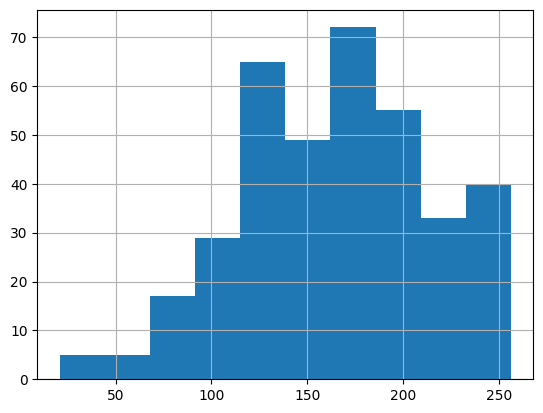

In [31]:
# Подберем chunk size - распределение длинны чанков
len_chunks_ta = []

for ex in chunks_ta:
    for element in ex:
        len_chunks_ta.append(len(enc.encode(element)))
    
pd.Series(len_chunks_ta).hist()

In [32]:
for ex in chunks_ta:
    if len(ex) > 1:
        break

print(*ex, sep='\n')

Мошенничество, Фишинг, Пирамиды, Украли деньги, Банковская карта. У Ивана Сергеевича зазвонил телефон, номер был незнаком. Солидный мужской голос на фоне шума офиса звучал встревоженно: «Добрый день. Иван Сергеевич? Это служба безопасности банка „Лапша-Финанс“. Мы зафиксировали, что киберпреступники пытаются получить доступ к вашему личному кабинету. Надо срочно перевести все деньги на безопасный счет, иначе их украдут!» Иван Сергеевич немедленно положил трубку. Рассказываем, по каким признакам он
наком. Солидный мужской голос на фоне шума офиса звучал встревоженно: «Добрый день. Иван Сергеевич? Это служба безопасности банка „Лапша-Финанс“. Мы зафиксировали, что киберпреступники пытаются получить доступ к вашему личному кабинету. Надо срочно перевести все деньги на безопасный счет, иначе их украдут!» Иван Сергеевич немедленно положил трубку. Рассказываем, по каким признакам он вычислил обманщиков.


In [33]:
data_cp['annotation_tags_chunk'] = chunks_ta

data_cp.head()

,id,annotation,tags,text,annotation_tags_chunk
0,doc_001,Светлана из Казани дает частные уроки английск...,"Начать бизнес, Самозанятые, Свое дело, Налоги","[(Кто такой самозанятый?, По закону самозаняты...","[Начать бизнес, Самозанятые, Свое дело, Налоги..."
1,doc_002,"Елене назначили социальное пособие на ребенка,...","Защитить права, Банки, Банковская карта, Риски...","[(, Первым делом нужно попросить банк проверит...","[Защитить права, Банки, Банковская карта, Риск..."
2,doc_003,Самый надежный способ не оказаться в долгах — ...,"Кредиты, Долги, Просрочки, Ипотека, Кредитная ...","[(, Не переоценивайте свои финансовые возможно...","[Кредиты, Долги, Просрочки, Ипотека, Кредитная..."
3,doc_004,"Друзья Александра то и дело хвастаются, что по...","Инвестиции, Ценные бумаги, Фондовая биржа, Акц...","[(, Просто прийти на биржу и купить ценные бум...","[Инвестиции, Ценные бумаги, Фондовая биржа, Ак..."
4,doc_005,Вы взяли в микрофинансовой организации заем на...,"Займы, Долги, Риски, Защитить права","[(МФО больше нет в госреестре. Значит, она зак...","[Займы, Долги, Риски, Защитить права. Вы взяли..."


#### 4.2 text

In [34]:
# Собираем чанки
chunks_t = list()

for row in data_cp['text']:
    doc_chunks = list()
    for doc in row:
        question, answer = doc[0], doc[1]
        doc_chunks.append(chunkinizer(question=question, answer=answer, chunk_size=756))

    chunks_t.append(doc_chunks)

In [35]:
# Количество объектов, количество документов в первом объекте
len(chunks_t), len(chunks_t[0])

(350, 13)

In [430]:
chunks_t[0][3]

['Кто может получить статус самозанятого?Этот вариант подойдет людям, у которых:  * есть собственное дело; * нет наемных сотрудников; * профессиональный доход за год не превышает 2,4 млн рублей.  Если у индивидуального предпринимателя нет штата работников, он тоже может получить статус самозанятого — и перейти со своей налоговой системы на НПД.  Например, оформиться как самозанятые могут репетиторы, няни, дизайнеры и многие другие фрилансеры. В законе нет полного списка профессий и видов деятельности, разрешенных для самозанятых. Зато прописано, кто не вправе претендовать на этот статус:  * продавцы товаров, которые произвел кто-то другой; * посредники и агенты; * продавцы алкоголя, сигарет, лекарств, лотерейных билетов, изделий из меха и кожи и других товаров, требующих обязательной маркировки; * люди, которые частным порядком добывают полезные ископаемые; * госслужащие; * адвокаты, частные нотариусы, арбитражные управляющие, медиаторы и оценщики — но только по своей основной специаль

<Axes: >

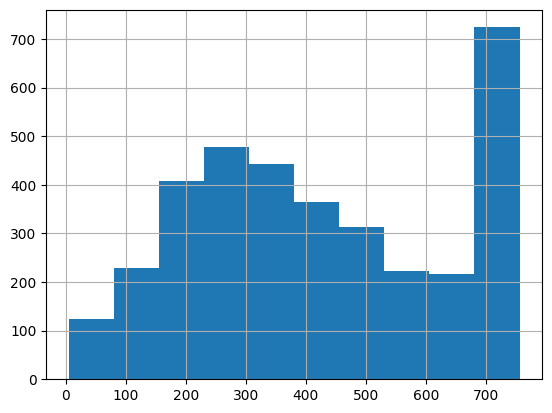

In [431]:
# Подберем chunk size - распределение длинны чанков
len_chunks_t = []

for ex in chunks_t:
    for element in ex:
        for string in element:
            len_chunks_t.append(len(enc.encode(string))) 
        
pd.Series(len_chunks_t).hist()

In [44]:
data_cp['text_chunk'] = chunks_t

data_cp.head()

,id,annotation,tags,text,annotation_tags_chunk,text_chunk
0,doc_001,Светлана из Казани дает частные уроки английск...,"Начать бизнес, Самозанятые, Свое дело, Налоги","[(Кто такой самозанятый?, По закону самозаняты...","[Начать бизнес, Самозанятые, Свое дело, Налоги...",[[Кто такой самозанятый?По закону самозанятый ...
1,doc_002,"Елене назначили социальное пособие на ребенка,...","Защитить права, Банки, Банковская карта, Риски...","[(, Первым делом нужно попросить банк проверит...","[Защитить права, Банки, Банковская карта, Риск...",[[Первым делом нужно попросить банк проверить ...
2,doc_003,Самый надежный способ не оказаться в долгах — ...,"Кредиты, Долги, Просрочки, Ипотека, Кредитная ...","[(, Не переоценивайте свои финансовые возможно...","[Кредиты, Долги, Просрочки, Ипотека, Кредитная...",[[Не переоценивайте свои финансовые возможност...
3,doc_004,"Друзья Александра то и дело хвастаются, что по...","Инвестиции, Ценные бумаги, Фондовая биржа, Акц...","[(, Просто прийти на биржу и купить ценные бум...","[Инвестиции, Ценные бумаги, Фондовая биржа, Ак...",[[Просто прийти на биржу и купить ценные бумаг...
4,doc_005,Вы взяли в микрофинансовой организации заем на...,"Займы, Долги, Риски, Защитить права","[(МФО больше нет в госреестре. Значит, она зак...","[Займы, Долги, Риски, Защитить права. Вы взяли...","[[МФО больше нет в госреестре. Значит, она зак..."


Каждый объект таблицы пораждает 2 документа: annotation + tags	и text. 

Для каждого объекта таблицы получаем эмбединги для первого документа (1-k штук), для второго документа (1-n штук).

Для каждого вида документов - свои БД

In [216]:
import pickle

with open('data/prepared_data_frame.pickle', 'wb') as f:
    pickle.dump(data_cp, f)

## 5. Получим тестовые эмбединги

In [140]:
from dotenv import load_dotenv
import os
from openai import OpenAI

# Load environment variables from .env file
load_dotenv() 

EMBEDER_KEY = os.getenv('EMBEDER_KEY')

True

___Готовим БД___

In [133]:
def data_to_storage(id_series: pd.Series, data_series: pd.Series):
    '''Функция парсит данные из датасета
    id_series - столбец с идентификатором документа
    data_series - стобец с чанками
    '''
    storage = {}
    key_id = 0

    for row_num in range(len(data_cp)):
        id_doc = id_series[row_num]
        data_document = data_series[row_num]

        for document in data_document:
            # Проверка на дополнительную вложенность
            if isinstance(document, list):
                for chunk in document:

                    storage[key_id] = (id_doc, chunk)
                    key_id += 1
            else:
                storage[key_id] = (id_doc, document)
                key_id += 1

    print(f"Storage ready, key from 0 to {key_id-1}")

    return storage

In [135]:
storage_an_t = data_to_storage(id_series=data_cp['id'], data_series=data_cp['annotation_tags_chunk'])

Storage ready, key from 0 to 369


In [151]:
def get_embedding(text):
    # Подключаемся к модели
    client = OpenAI(
        # Базовый url - сохранять без изменения
        base_url="https://ai-for-finance-hack.up.railway.app/",
        # Указываем наш ключ, полученный ранее
        api_key=EMBEDER_KEY,
    )
    # Формируем запрос к клиенту
    response = client.embeddings.create(
        # Выбираем любую допступную модель из предоставленного списка
        model="text-embedding-3-small",
        # Отправяем запрос
        input=text, 
        # Определяем размерность эмбединга
        dimensions = 512
    )
    # Формируем ответ на запрос и возвращаем его в результате работы функции
    return response.data[0].embedding


In [159]:
def get_batch_embeddings(texts, batch_size=32):
    """Батчевые запросы к embedding API

    Args:
        texts: список строк
        batch_size: количество текстов в одном запросе

    Returns:
        Список эмбеддингов (list[list[float]]).
    """
    client = OpenAI(
        base_url="https://ai-for-finance-hack.up.railway.app/",
        api_key=EMBEDER_KEY,
    )

    embeddings = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]

        response = client.embeddings.create(
            model="text-embedding-3-small",
            input=batch,            
            dimensions=512
        )

        # каждая запись в response.data соответствует одному элементу из batch
        batch_embeddings = [item.embedding for item in response.data]
        embeddings.extend(batch_embeddings)

    return embeddings


In [174]:
# Соберем текст для батчевого запроса
texts = list()
for key, val in storage_an_t.items():
    texts.append(val[1])

len(texts)

370

In [175]:
# %%time
# Запрос к openrouter
embeddings = get_batch_embeddings(texts)

CPU times: user 99 ms, sys: 43.3 ms, total: 142 ms
Wall time: 13.7 s


(370, 512)

In [183]:
# Соберем временное хранилище векторов
embed_storage_an_t = dict()

for i in range(len(embeddings)):
    embed_storage_an_t[i] = np.array(embeddings[i], np.float32)

with open('data/embed_storage_an_t.pickle', 'wb') as f:
    pickle.dump(embed_storage_an_t, f)

___Init faiss db___

In [ ]:
# todo - не добавлено в логику
def normalize_vector(embedding: np.ndarray) -> np.ndarray:
    """
    Normalizes a given vector to have unit length.

    Args:
        embedding (np.ndarray): A NumPy array representing the vector to normalize.

    Returns:
        np.ndarray: A normalized vector with unit length.
    """

    norm = np.linalg.norm(embedding)
    if abs(norm) >= 1e-9: #защита от взрыва и погрешности
      embedding /= norm

    return embedding

In [202]:
# Function to populate the FAISS index
def populate_faiss_index(index: faiss.Index, documents: dict, batch_size: int=20):
    """
    populate_faiss_index: Add a description here.

    Args:
        # List the arguments with types and descriptions.

    Returns:
        # Specify what the function returns.
    """
    """
    Populates the FAISS HNSW index with normalized embeddings from the dataset.

    Parameters:
        index (faiss.Index): FAISS index to populate.
        documents (pd.Series): documents like List[list[str]]
        batch_size (int): Number of questions to process at a time.
    """
    buffer = []
    i = 0

    for _, embedding in documents.items():
        embedding = normalize_vector(embedding)
        buffer.append(embedding)
        i += 1

        # Add embeddings to the index in batches
        if len(buffer) >= batch_size:
            index.add(np.array(buffer, dtype=np.float32))
            buffer = []

    # Add remaining embeddings
    if buffer:
        index.add(np.array(buffer, dtype=np.float32))

In [203]:
# Define the dimensions of the embedding vectors
embedding_dimension = 512  # Depends on the FastText model

# Build the HNSW index
hnsw_index_an_t = build_faiss_hnsw_index(embedding_dimension)

# Populate the index from pd.Series
populate_faiss_index(index=hnsw_index_an_t, documents=embed_storage_an_t)

In [215]:
# Пример, ключ в storage и hnsw_index сквозной (одинаковый)
example_chunk = embed_storage_an_t[0]
example = normalize_vector(example_chunk)

top_k_indices, top_k_similarities = hnsw_index_an_t.search(np.array([example], dtype=np.float32), 1)

assert (example_chunk == embed_storage_an_t[top_k_similarities.item()]).all(), 'Вернулся другой чанк!'

## 6. Faiss

In [36]:
import faiss

In [86]:
def normalize_vector(embedding: np.ndarray) -> np.ndarray:
    """
    Normalizes a given vector to have unit length.

    Args:
        embedding (np.ndarray): A NumPy array representing the vector to normalize.

    Returns:
        np.ndarray: A normalized vector with unit length.
    """

    norm = np.linalg.norm(embedding)
    if abs(norm) >= 1e-9: #защита от взрыва и погрешности
      embedding /= norm

    return embedding

In [84]:
def get_text_embedding(chunk, size=756):

    assert isinstance(chunk, str), f'Type Error! type: {type(chunk)}, {chunk}'

    # tood list to np.array
    embed = enc.encode(chunk)
    pad_len = size - len(embed)
    embed.extend([0]*pad_len) # Fake pad tocken    

    embed = np.array(embed[:size], dtype=np.float32) # защита от дурака

    return normalize_vector(embed)

In [38]:
# Function to build an HNSW index
def build_faiss_hnsw_index(dimension, ef_construction=200, M=32):
    """
    build_faiss_hnsw_index: Add a description here.

    Args:
        # List the arguments with types and descriptions.

    Returns:
        # Specify what the function returns.
    """
    """
    Builds a FAISS HNSW index for cosine similarity.

    Parameters:
        dimension (int): Dimensionality of the embeddings.
        ef_construction (int): Trade-off parameter between index construction speed and accuracy.
        M (int): Number of neighbors in the graph.

    Returns:
        index (faiss.IndexHNSWFlat): Initialized FAISS HNSW index.
    """
    index = faiss.IndexHNSWFlat(dimension, M)  # HNSW index
    index.hnsw.efConstruction = ef_construction  # Construction accuracy
    index.metric_type = faiss.METRIC_INNER_PRODUCT  # Cosine similarity via normalized vectors
    return index

In [39]:
# Function to populate the FAISS index
def populate_faiss_index(index: faiss.Index, documents: dict, batch_size: int=20):
    """
    populate_faiss_index: Add a description here.

    Args:
        # List the arguments with types and descriptions.

    Returns:
        # Specify what the function returns.
    """
    """
    Populates the FAISS HNSW index with normalized embeddings from the dataset.

    Parameters:
        index (faiss.Index): FAISS index to populate.
        documents (pd.Series): documents like List[list[str]]
        batch_size (int): Number of questions to process at a time.
    """
    buffer = []
    i = 0

    for _, embedding in documents.items():
        embedding = get_text_embedding(v[1])
        buffer.append(embedding)
        i += 1

        # Add embeddings to the index in batches
        if len(buffer) >= batch_size:
            index.add(np.array(buffer, dtype=np.float32))
            buffer = []

    # Add remaining embeddings
    if buffer:
        index.add(np.array(buffer, dtype=np.float32))

In [40]:
# Function to perform a search query
def search_faiss_index(embeddings_storage, query, k=5):
    """
    search_faiss_index: Add a description here.

    Args:
        # List the arguments with types and descriptions.

    Returns:
        # Specify what the function returns.
    """
    """
    Searches the FAISS index for the closest matches to a query.

    Parameters:
        embeddings_storage (faiss.Index): FAISS index to search.
        query (str): Query string to search.
        k (int): Number of closest matches to retrieve.

    Returns:
        indices (np.ndarray): Indices of the top-k results.
        distances (np.ndarray): Distances of the top-k results.
    """
    # Preprocess and normalize the query embedding
    query_embedding = get_text_embedding(query)

    # Search the embeddings_storage
    top_k_distances, top_k_indices = embeddings_storage.search(np.array([query_embedding], dtype=np.float32), k)

    # Match return format with that used in numpy storage search
    # Note that list manipulations will give an overhead
    top_k_indices_list = top_k_indices[0].tolist()
    top_k_distances_list = top_k_distances[0].tolist()

    return top_k_indices_list, top_k_distances_list

In [41]:
def fetch_and_display_closest_match(query_function, storage_id, **kwargs):
    """
    fetch_and_display_closest_match: Add a description here.

    Args:
        # List the arguments with types and descriptions.

    Returns:
        # Specify what the function returns.
    """
    """
    A utility function for visual testing.
    """
    top_k_indices, top_k_similarities = query_function(**kwargs)

    # # Fetch and display results
    top_k_chunk = [storage_id[i][0] for i in top_k_indices]

    print(f"Query: {kwargs['query']}")
    print("\nTop Matches:")
    for i, (question, similarity) in enumerate(zip(top_k_chunk, top_k_similarities), 1):
        print(f"{i}. {question} (Similarity: {similarity:.4f})")

    return top_k_indices, top_k_similarities


In [42]:
def data_to_storage(id_series: pd.Series, data_series: pd.Series):
    '''Функция парсит данные из датасета
    id_series - столбец с идентификатором документа
    data_series - стобец с чанками
    '''
    storage = {}
    key_id = 0

    for row_num in range(len(data_cp)):
        id_doc = id_series[row_num]
        data_document = data_series[row_num]

        for document in data_document:
            for chunk in document:

                storage[key_id] = (id_doc, chunk)
                key_id += 1

    print(f"Storage ready, key from 0 to {key_id-1}")

    return storage

In [87]:
# Pd Series(List[List[Str]]) -> {id : (doc_id, chunk)}
storage = data_to_storage(id_series = data_cp['id'], data_series = data_cp['text_chunk'])

# Define the dimensions of the embedding vectors
embedding_dimension = 756  # Depends on the FastText model

# Build the HNSW index
hnsw_index = build_faiss_hnsw_index(embedding_dimension)

# Populate the index from pd.Series
populate_faiss_index(index=hnsw_index, documents=storage)

Storage ready, key from 0 to 3048


In [122]:
# Пример, ключ в storage и hnsw_index сквозной (одинаковый)
example_chunk = storage[3][1]
example = get_text_embedding(example_chunk)

top_k_indices, top_k_similarities = hnsw_index.search(np.array([example], dtype=np.float32), 1)

assert example_chunk == storage[top_k_similarities.item()][1], 'Вернулся другой чанк!'

In [123]:
# Example query (сейчас вектор заполняется 0, поэтому нахолится сходство с эмбедингами состоящими из 0)
query_text = "Кто такой самозанятый?"

top_k_indices, top_k_similarities = fetch_and_display_closest_match(query_function=search_faiss_index,
                                                                    query=query_text,
                                                                    embeddings_storage=hnsw_index,
                                                                    storage_id=storage,
                                                                    k=10)

Query: Кто такой самозанятый?

Top Matches:
1. doc_333 (Similarity: -0.9123)
2. doc_266 (Similarity: -1.1462)
3. doc_035 (Similarity: -1.3048)
4. doc_256 (Similarity: -1.3117)
5. doc_099 (Similarity: -1.3409)
6. doc_188 (Similarity: -1.3618)
7. doc_327 (Similarity: -1.4123)
8. doc_347 (Similarity: -1.4144)
9. doc_102 (Similarity: -1.4219)
10. doc_120 (Similarity: -1.4287)
